Want to calculate the risk adjusted returns for the NASDAQ100 stock over the period we are looking at.
Risk-adjusted returns are a way to assess an investment's performance relative to its risk. One of the most common measures for risk-adjusted returns is the Sharpe ratio.

Formula:
$$\text{Sharpe ratio} = \frac{\text{Risk premium}}{\text{SD of excess return}}$$
that is:
𝑆ℎ𝑎𝑟𝑝𝑒 𝑟𝑎𝑡𝑖𝑜=(𝐸(𝑟_𝐸𝐷 )−𝑟_𝑓)/𝜎_𝐸𝐷 

Sharpe Ratio = (Average Return of Investment - Risk-Free Rate) / Standard Deviation of Investment

First we need the average return, since we want to calculate this daily we can just use the daily return instead of average.
Calculate it using: Daily Return = (Price at Day N - Price at Day N-1) / Price at Day N-1
(so not log return?)

In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [113]:
# first we need the historical data: 
url_nasdaq_price = 'https://raw.githubusercontent.com/inga-maria01/master_thesis/main/data/Nasdaq100_price_data.csv'
price_df = pd.read_csv(url_nasdaq_price)
price_df['Date'] = pd.to_datetime(price_df['Date'])
price_df.head()
#this dataset includes the prices and the volume!
# we now need to calculate the returns, do this by taking the logarithm and first difference of the closing price.


,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-12-31,4294.879883,4307.009766,4233.709961,4236.279785,4236.279785,1515600000
1,2015-01-02,4258.600098,4276.709961,4206.459961,4230.240234,4230.240234,1435150000
2,2015-01-05,4206.549805,4210.959961,4151.850098,4160.959961,4160.959961,1794470000
3,2015-01-06,4174.779785,4176.259766,4090.330078,4110.830078,4110.830078,2167320000
4,2015-01-07,4139.850098,4169.970215,4126.390137,4160.000000,4160.000000,1957950000


In [114]:
price_df['r_ndq'] = np.log(price_df['Close']).diff()*100 #have in percentages
price_df.dropna(inplace=True)
price_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,r_ndq
1,2015-01-02,4258.600098,4276.709961,4206.459961,4230.240234,4230.240234,1435150000,-0.142669
2,2015-01-05,4206.549805,4210.959961,4151.850098,4160.959961,4160.959961,1794470000,-1.651298
3,2015-01-06,4174.779785,4176.259766,4090.330078,4110.830078,4110.830078,2167320000,-1.212083
4,2015-01-07,4139.850098,4169.970215,4126.390137,4160.000000,4160.000000,1957950000,1.189010
5,2015-01-08,4195.490234,4247.930176,4192.629883,4240.549805,4240.549805,2105450000,1.917786


Portfolio: use model to rebalance every day, and then calculate monthly sharpe ratio to compare the two portfolios (ours and the benchmark)

Steps we need:
- Add risk free returns to the data
- Calculate the returns for the benchmark portfolio
    - To do that: w_rf = 0.4, w_s = 0.6, r_bm = w_rf*r_rf + w_s *r_s
    - calculate them daily and then calculate monthly sharpe ratio:
        - to do that: Get monthly standard deviation -> based on date column 
        - get average monthly return for both the portfolio and just the risk free
        - calculate risk premium (r_bm - r_rf)
        - calculate sharpe ratio: risk premium / std_bm

**1. Get rf data:**

- 1. Load the data
- 2. Calculate daily returns
- 3. Add to dataframe (or make new dataframe with just the relevant info)


Here I download data from https://www.investing.com/rates-bonds/us-10-yr-t-note-historical-data
that is, it's data about the price of a future of the 10 year US treasury note I think.

In [115]:
rf_df = pd.read_csv('https://raw.githubusercontent.com/inga-maria01/master_thesis/main/data/US%2010%20Year%20T-Note%20Futures%20Historical%20Data.csv')

In [116]:
rf_df['r_rf'] = np.log(rf_df['Price']).diff()*100
rf_df.dropna(inplace=True)

In [117]:
rf_df.head()

,Date,Price,Open,High,Low,Vol.,Change %,r_rf
1,12/30/2019,128.53,128.61,128.69,128.16,891.50K,-0.10%,0.085620
2,12/27/2019,128.66,128.41,128.67,128.39,667.29K,0.22%,0.101093
3,12/26/2019,128.38,128.36,128.47,128.20,402.21K,0.02%,-0.217865
5,12/24/2019,128.31,128.14,128.39,128.00,398.67K,0.17%,-0.031170
6,12/23/2019,128.09,128.22,128.39,128.05,620.13K,-0.12%,-0.171607


not sure what change % is...

In [118]:
rf_df['Date'] = pd.to_datetime(rf_df['Date'])

**2. Calculate daily 60/40 portfolio returns**
- Use w_rf*r_rf + w_nq+r_nq

In [119]:
benchmark6040_df = pd.merge(price_df[['Date', 'r_ndq']], 
                     rf_df[['Date', 'r_rf']], 
                     on='Date', 
                     how='inner')

benchmark6040_df.head()

,Date,r_ndq,r_rf
0,2015-01-02,-0.142669,-0.478564
1,2015-01-05,-1.651298,-0.460704
2,2015-01-06,-1.212083,-0.085660
3,2015-01-07,1.189010,0.280614
4,2015-01-08,1.917786,-0.366201


In [120]:
w_rf = 0.4
w_ndq = 0.6

In [121]:
benchmark6040_df['r_bm'] = w_rf*benchmark6040_df['r_rf'] + w_ndq*benchmark6040_df['r_ndq']

In [122]:
benchmark6040_df.head()

,Date,r_ndq,r_rf,r_bm
0,2015-01-02,-0.142669,-0.478564,-0.277027
1,2015-01-05,-1.651298,-0.460704,-1.175060
2,2015-01-06,-1.212083,-0.085660,-0.761514
3,2015-01-07,1.189010,0.280614,0.825652
4,2015-01-08,1.917786,-0.366201,1.004191


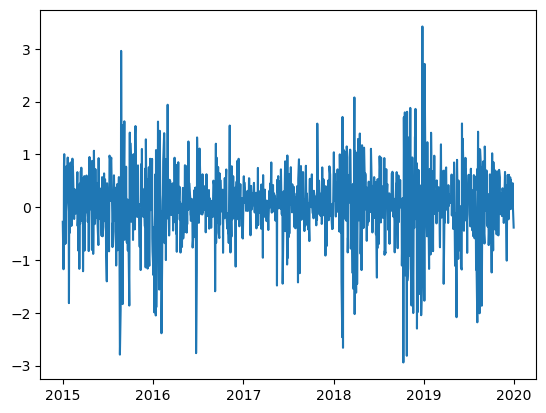

In [123]:
plt.plot(benchmark6040_df['Date'], benchmark6040_df['r_bm'])

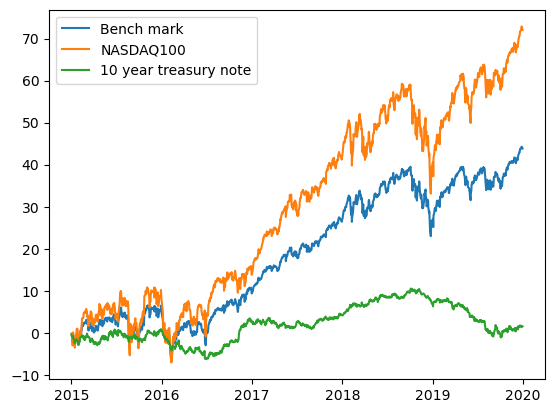

In [139]:
values_bm = benchmark6040_df['r_bm'].cumsum()
values_ndq = benchmark6040_df['r_ndq'].cumsum()
values_rf = benchmark6040_df['r_rf'].cumsum()

plt.plot(benchmark6040_df['Date'], values_bm, label='Bench mark')
plt.plot(benchmark6040_df['Date'], values_ndq, label='NASDAQ100')
plt.plot(benchmark6040_df['Date'], values_rf, label = '10 year treasury note')
plt.legend()

In [152]:
100*np.exp(-0.14)*np.exp(-1.65)*np.exp(-1.21)*np.exp(1.19)*np.exp(1.91)

110.51709180756477

Final value of portfolio:  155.0540086415138


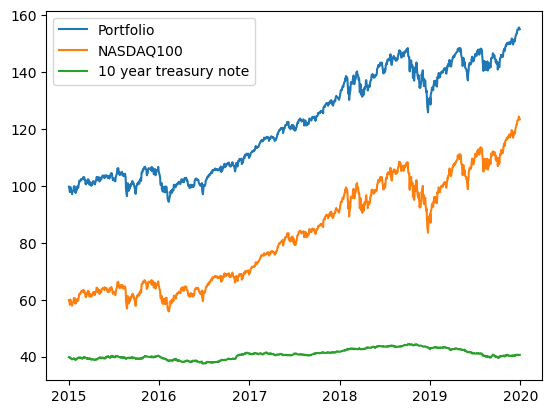

In [160]:
P = 60
history_ndq = [P]
for i in range(len(values_bm)):
    P = P*np.exp(benchmark6040_df['r_ndq'][i]/100)
    history_ndq.append(P)
    

P = 40
history_rf = [P]
for i in range(len(values_bm)):
    P = P*np.exp(benchmark6040_df['r_rf'][i]/100)
    history_rf.append(P)


P = 100
history_bm = [P]
for i in range(len(values_bm)):
    P = P*np.exp(benchmark6040_df['r_bm'][i]/100)
    history_bm.append(P)

print('Final value of portfolio: ', P)

plt.plot(benchmark6040_df['Date'], history_bm[1:], label='Portfolio')
plt.plot(benchmark6040_df['Date'], history_ndq[1:], label='NASDAQ100')
plt.plot(benchmark6040_df['Date'], history_rf[1:], label = '10 year treasury note')
plt.legend()

In [65]:
benchmark6040_df['r_bm'].sum()

43.86033130875216

In [66]:
benchmark6040_df['r_ndq'].sum()

72.07553704828662

In [67]:
benchmark6040_df['r_rf'].sum()

1.5375226994504665

**3. Calculate the monthly returns and standard devitations for the Sharpe ratio**

In [68]:
benchmark6040_df.loc[benchmark6040_df.index, 'r_ndq']

0      -0.142669
1      -1.651298
2      -1.212083
3       1.189010
4       1.917786
          ...   
1252    0.201670
1253    0.040240
1254    0.901718
1255   -0.083526
1256   -0.700775
Name: r_ndq, Length: 1257, dtype: float64

In [69]:
# Set 'Date' as the index of the DataFrame
benchmark6040_df.set_index('Date', inplace=True)

# Resample the data by month and calculate mean and standard deviation for specific columns
monthly_stats = benchmark6040_df.resample('M').agg({
    'r_ndq': ['mean', 'std'],
    'r_rf': ['mean', 'std'],
    'r_bm': 'mean',
    })


# Flatten the MultiIndex in columns created by agg()
monthly_stats.columns = ['_'.join(map(str, col)).strip() if isinstance(col, tuple) else col for col in monthly_stats.columns.values]

grouped = benchmark6040_df.resample('M')
covariances = []
for month in grouped:
    cov = np.cov(month[1]['r_ndq'], month[1]['r_rf'])[0,1]
    row = {'Date': month[0], 'covariance': cov}
    covariances.append(row)

covariances = pd.DataFrame(covariances)
covariances.set_index('Date', inplace=True)

# Combine the results
monthly_stats = pd.concat([monthly_stats, covariances], axis=1)

print(monthly_stats)


            r_ndq_mean  r_ndq_std  r_rf_mean  r_rf_std  r_bm_mean  covariance
Date                                                                         
2015-01-31   -0.104777   1.198388  -0.144931  0.321663  -0.120839    0.055723
2015-02-28    0.358291   0.599885   0.100132  0.375948   0.255027    0.013360
2015-03-31   -0.110845   0.952409  -0.056918  0.339423  -0.089274    0.001097
2015-04-30    0.087708   0.794675   0.040894  0.260074   0.068982   -0.050211
2015-05-31    0.105356   0.880431   0.008616  0.362429   0.066660   -0.021629
2015-06-30   -0.113824   0.802078   0.075092  0.469830  -0.038258   -0.065618
2015-07-31    0.194430   0.907897  -0.068179  0.305180   0.089387   -0.028983
2015-08-31   -0.337889   1.999347  -0.001862  0.372983  -0.203478   -0.015679
2015-09-30   -0.105338   1.585170  -0.023711  0.334493  -0.072687   -0.119491
2015-10-31    0.482049   0.918805   0.048626  0.300474   0.308680    0.064282
2015-11-30    0.016836   0.854377  -0.005492  0.209434   0.00790

In [70]:
#calculate standard deviation of the portfolio per month:

monthly_stats['std_bm'] = np.sqrt(w_ndq**2*monthly_stats['r_ndq_std']**2 + w_rf**2*monthly_stats['r_rf_std']**2 + 2*w_ndq*w_rf*monthly_stats['covariance'])

monthly_stats.head()

,r_ndq_mean,r_ndq_std,r_rf_mean,r_rf_std,r_bm_mean,covariance,std_bm
Date,,,,,,,
2015-01-31,-0.104777,1.198388,-0.144931,0.321663,-0.120839,0.055723,0.748538
2015-02-28,0.358291,0.599885,0.100132,0.375948,0.255027,0.013360,0.398217
2015-03-31,-0.110845,0.952409,-0.056918,0.339423,-0.089274,0.001097,0.587800
2015-04-30,0.087708,0.794675,0.040894,0.260074,0.068982,-0.050211,0.462670
2015-05-31,0.105356,0.880431,0.008616,0.362429,0.066660,-0.021629,0.538230


In [71]:
monthly_stats = monthly_stats.reset_index()
monthly_stats.head()

,Date,r_ndq_mean,r_ndq_std,r_rf_mean,r_rf_std,r_bm_mean,covariance,std_bm
0,2015-01-31,-0.104777,1.198388,-0.144931,0.321663,-0.120839,0.055723,0.748538
1,2015-02-28,0.358291,0.599885,0.100132,0.375948,0.255027,0.013360,0.398217
2,2015-03-31,-0.110845,0.952409,-0.056918,0.339423,-0.089274,0.001097,0.587800
3,2015-04-30,0.087708,0.794675,0.040894,0.260074,0.068982,-0.050211,0.462670
4,2015-05-31,0.105356,0.880431,0.008616,0.362429,0.066660,-0.021629,0.538230


In [72]:

# Change index to the first of each month
monthly_stats['Date'] = pd.to_datetime(monthly_stats['Date']).dt.to_period('M').dt.to_timestamp().dt.date
monthly_stats.head()


,Date,r_ndq_mean,r_ndq_std,r_rf_mean,r_rf_std,r_bm_mean,covariance,std_bm
0,2015-01-01,-0.104777,1.198388,-0.144931,0.321663,-0.120839,0.055723,0.748538
1,2015-02-01,0.358291,0.599885,0.100132,0.375948,0.255027,0.013360,0.398217
2,2015-03-01,-0.110845,0.952409,-0.056918,0.339423,-0.089274,0.001097,0.587800
3,2015-04-01,0.087708,0.794675,0.040894,0.260074,0.068982,-0.050211,0.462670
4,2015-05-01,0.105356,0.880431,0.008616,0.362429,0.066660,-0.021629,0.538230


In [73]:
monthly_stats.head()

,Date,r_ndq_mean,r_ndq_std,r_rf_mean,r_rf_std,r_bm_mean,covariance,std_bm
0,2015-01-01,-0.104777,1.198388,-0.144931,0.321663,-0.120839,0.055723,0.748538
1,2015-02-01,0.358291,0.599885,0.100132,0.375948,0.255027,0.013360,0.398217
2,2015-03-01,-0.110845,0.952409,-0.056918,0.339423,-0.089274,0.001097,0.587800
3,2015-04-01,0.087708,0.794675,0.040894,0.260074,0.068982,-0.050211,0.462670
4,2015-05-01,0.105356,0.880431,0.008616,0.362429,0.066660,-0.021629,0.538230


**4. Get the risk free rate (GS1M)**

In [74]:
r_rf_df = pd.read_csv('https://raw.githubusercontent.com/inga-maria01/master_thesis/main/data/GS1M.csv')
r_rf_df.head()

,DATE,GS1M
0,2015-01-01,0.02
1,2015-02-01,0.02
2,2015-03-01,0.02
3,2015-04-01,0.02
4,2015-05-01,0.01


In [75]:
#divide by 12 to get monthly returns instead of annual:
r_rf_df['monthly_rf'] = r_rf_df['GS1M']/12
r_rf_df.rename(columns = {'DATE':'Date'}, inplace = True)
r_rf_df.head()

,Date,GS1M,monthly_rf
0,2015-01-01,0.02,0.001667
1,2015-02-01,0.02,0.001667
2,2015-03-01,0.02,0.001667
3,2015-04-01,0.02,0.001667
4,2015-05-01,0.01,0.000833


**5. Finally: calculate the monthly sharpe ratio for the benchmark portfolio:**

In [86]:
sharpe_df = pd.merge(monthly_stats, r_rf_df, on='Date', how='left')

In [83]:
monthly_stats['Date'] = pd.to_datetime(monthly_stats['Date'])
monthly_stats.head()

,Date,r_ndq_mean,r_ndq_std,r_rf_mean,r_rf_std,r_bm_mean,covariance,std_bm
0,2015-01-01,-0.104777,1.198388,-0.144931,0.321663,-0.120839,0.055723,0.748538
1,2015-02-01,0.358291,0.599885,0.100132,0.375948,0.255027,0.013360,0.398217
2,2015-03-01,-0.110845,0.952409,-0.056918,0.339423,-0.089274,0.001097,0.587800
3,2015-04-01,0.087708,0.794675,0.040894,0.260074,0.068982,-0.050211,0.462670
4,2015-05-01,0.105356,0.880431,0.008616,0.362429,0.066660,-0.021629,0.538230


In [84]:
r_rf_df['Date'] = pd.to_datetime(r_rf_df['Date'])

In [87]:
sharpe_df.head()

,Date,r_ndq_mean,r_ndq_std,r_rf_mean,r_rf_std,r_bm_mean,covariance,std_bm,GS1M,monthly_rf
0,2015-01-01,-0.104777,1.198388,-0.144931,0.321663,-0.120839,0.055723,0.748538,0.02,0.001667
1,2015-02-01,0.358291,0.599885,0.100132,0.375948,0.255027,0.013360,0.398217,0.02,0.001667
2,2015-03-01,-0.110845,0.952409,-0.056918,0.339423,-0.089274,0.001097,0.587800,0.02,0.001667
3,2015-04-01,0.087708,0.794675,0.040894,0.260074,0.068982,-0.050211,0.462670,0.02,0.001667
4,2015-05-01,0.105356,0.880431,0.008616,0.362429,0.066660,-0.021629,0.538230,0.01,0.000833


In [88]:
sharpe_df['risk_premium'] = sharpe_df['r_bm_mean'] - sharpe_df['monthly_rf']

#sharpe_bm = risk_premium / monthly_stats['std_bm']

In [90]:
sharpe_df['sharpe_ratio'] = sharpe_df['risk_premium']/sharpe_df['std_bm']
sharpe_df.head()

,Date,r_ndq_mean,r_ndq_std,r_rf_mean,r_rf_std,r_bm_mean,covariance,std_bm,GS1M,monthly_rf,risk_premium,sharpe_ratio
0,2015-01-01,-0.104777,1.198388,-0.144931,0.321663,-0.120839,0.055723,0.748538,0.02,0.001667,-0.122506,-0.163660
1,2015-02-01,0.358291,0.599885,0.100132,0.375948,0.255027,0.013360,0.398217,0.02,0.001667,0.253361,0.636237
2,2015-03-01,-0.110845,0.952409,-0.056918,0.339423,-0.089274,0.001097,0.587800,0.02,0.001667,-0.090941,-0.154714
3,2015-04-01,0.087708,0.794675,0.040894,0.260074,0.068982,-0.050211,0.462670,0.02,0.001667,0.067316,0.145494
4,2015-05-01,0.105356,0.880431,0.008616,0.362429,0.066660,-0.021629,0.538230,0.01,0.000833,0.065826,0.122302


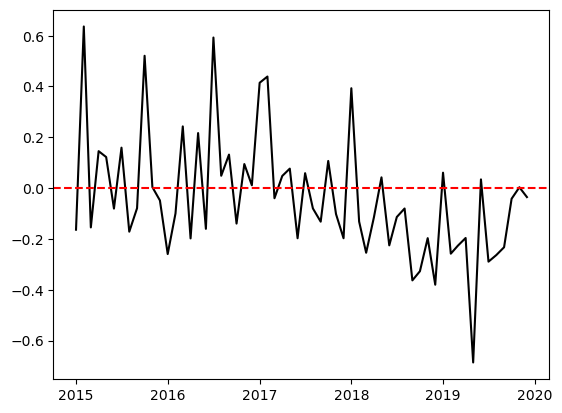

In [97]:
plt.plot(sharpe_df['Date'], sharpe_df['sharpe_ratio'], color = 'black')
plt.axhline(0, color = 'red', linestyle = '--')

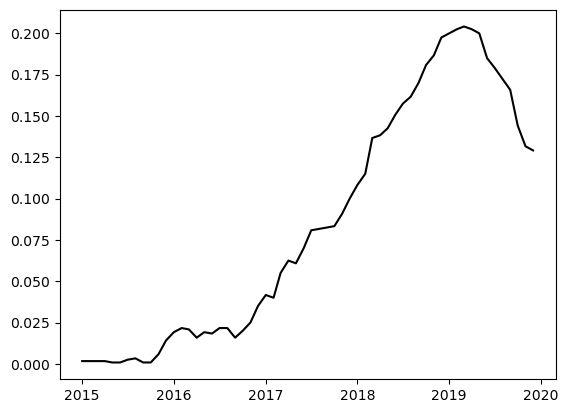

In [98]:
plt.plot(sharpe_df['Date'], sharpe_df['monthly_rf'], color = 'black')

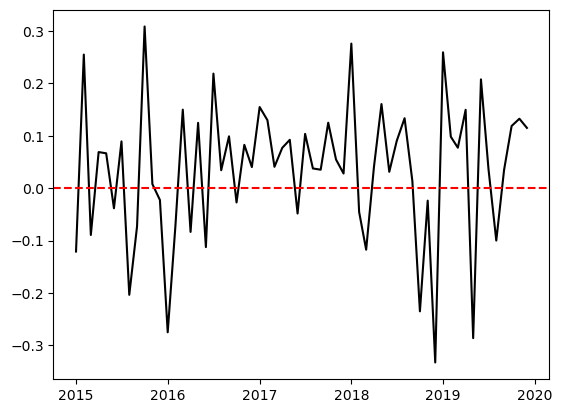

In [96]:
plt.plot(sharpe_df['Date'], sharpe_df['r_bm_mean'], color = 'black')
plt.axhline(0, color = 'red', linestyle = '--')

In [99]:
np.average(sharpe_df['sharpe_ratio'])

-0.035283675361615995

In [102]:
std_ndq_m = np.std(sharpe_df['r_ndq_mean'])
std_rf_m = np.std(sharpe_df['r_rf_mean'])
cov_m = np.cov(sharpe_df['r_ndq_mean'], sharpe_df['r_rf_mean'])[0,1]

std_bm_m = np.sqrt(w_ndq**2 * std_ndq_m + w_rf**2 * std_rf_m + 2*w_ndq*w_rf*cov_m)

average_return = np.average(sharpe_df['r_bm_mean'])
rf_return = np.average(sharpe_df['monthly_rf'])

sharpe_total = (average_return-rf_return)/std_bm_m

sharpe_total

-0.170404846341756

In [106]:
z = (103.9-104)/104*100

In [108]:
100*(1+z)

90.38461538461593

In [109]:
z2 = (106-103.9)/103.9

In [110]:
90.3946*(1+z2)

92.2216323387873